# ANALYSIS

In [1]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import sklearn

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM



#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from collections import Counter
import os

In [3]:
# Data loader
trainingData = pd.read_csv('../FinalData/trainingDataEncoded_08102023.csv')
validationData = pd.read_csv('../FinalData/validationDataEncoded_08102023.csv')
evaluationData = pd.read_csv('../FinalData/evaluationDataEncoded_08102023.csv')
evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWalesEncoded_08102023.csv')
evaluationDataScotland = pd.read_csv('../FinalData/evaluationDataScotlandEncoded_08102023.csv')

trainingData = trainingData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
validationData = validationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationData = evaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataWales = evaluationDataWales.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataScotland = evaluationDataScotland.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)

/tmp/ipykernel_7734/2275218212.py:2: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  trainingData = pd.read_csv('../FinalData/trainingDataEncoded_08102023.csv')
/tmp/ipykernel_7734/2275218212.py:3: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  validationData = pd.read_csv('../FinalData/validationDataEncoded_08102023.csv')
/tmp/ipykernel_7734/2275218212.py:4: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  evaluationData = pd.read_csv('../FinalData/evaluationDataEncoded_08102023.csv')
/tmp/ipykernel_7734/2275218212.py:5: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWalesEncoded_08102023.csv')
/tmp/ipykernel_7734/2275218212.py:6: DtypeWarning: Columns (44,48,50) have mixed types. Specify dtype option on im

In [4]:
target_outcomes = ['3months', '6months', '12months', '24months'] 
for target_outcome in target_outcomes:
    print('#######################################################')
    print(target_outcome)
    print(trainingData[target_outcome].value_counts(normalize=True))
    print(validationData[target_outcome].value_counts(normalize=True))
    print(evaluationData[target_outcome].value_counts(normalize=True))
    print(evaluationDataWales[target_outcome].value_counts(normalize=True))
    print(evaluationDataScotland[target_outcome].value_counts(normalize=True))

#######################################################
3months
0    0.971952
1    0.028048
Name: 3months, dtype: float64
0    0.971477
1    0.028523
Name: 3months, dtype: float64
0    0.960263
1    0.039737
Name: 3months, dtype: float64
0    0.96127
1    0.03873
Name: 3months, dtype: float64
0    0.958513
1    0.041487
Name: 3months, dtype: float64
#######################################################
6months
0    0.958327
1    0.041673
Name: 6months, dtype: float64
0    0.958049
1    0.041951
Name: 6months, dtype: float64
0    0.938269
1    0.061731
Name: 6months, dtype: float64
0    0.942561
1    0.057439
Name: 6months, dtype: float64
0    0.930815
1    0.069185
Name: 6months, dtype: float64
#######################################################
12months
0    0.929795
1    0.070205
Name: 12months, dtype: float64
0    0.929794
1    0.070206
Name: 12months, dtype: float64
0    0.904447
1    0.095553
Name: 12months, dtype: float64
0    0.905212
1    0.094788
Name: 12months, dtype: f

In [5]:
#Define feature candidates

features_columns = trainingData.columns.to_list()
exclude_columns = ['patid', 'practice_id', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'cat_age', 'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS', 'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents', 
                   'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents', 'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI', 'cat_numAsthmaAttacks', 'cat_numHospEvents', 
                   'cat_numPCS', 'cat_numPCSAsthma', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   
                   'numOCSEvents', #duplicate with numOCS
                   
                   'month_12', 'month_4', 'month_5', 'month_10', 'month_1', 'month_6', 'month_3', 
                   'month_11', 'month_8', 'month_9', 'month_7', 'month_2', #month of attacks
                  ]
exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  59
['sex', 'BTS_step', 'PriorEducation', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'PEFStatus', 'EosinophilLevel', 'ethnic_group_Asian - ethnic group', 'ethnic_group_Black - ethnic group', 'ethnic_group_Mixed ethnic census group', 'ethnic_group_Other ethnic group', 'ethnic_group_White - ethnic group', 'ethnic_group_not_recorded', 'smokingStatus_Active Smoker', 'smokingStatus_Former Smoker', 'smokingStatus_Non Smoker', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_pMDI', 'DeviceType_unknown', 'cat_BMI_normal', 'cat_BMI_not recorded', 'cat_BMI_obese', 'cat_BMI_overweight', 'cat_BMI_underweight', 'imd_decile_0', 'imd_decile_1', 'imd_decile_2', 'imd_decile_3', 'imd_decile_4', 'imd_decile_5', 'imd_decile_6', 'imd_decile_7', 'imd_decile_8', 'imd_decile_9', 'imd_decile_10', 'age', 'CharlsonScore', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_poss

# UTILS

In [6]:
#Model evaluation function

def summariseResult (testX, testY, model):
    preds = model.predict(testX)
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    # aucscore = auc(fpr, tpr)
    aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

In [7]:
#Fix model name for visualisation

def modelNameFixer(x):
    if 'liblinear' in x:
        return 'Lasso'
    elif 'GaussianNB' in x:
        return 'GNB'
    elif 'SVC' in x:
        return 'SVC'
    elif 'RandomForest' in x:
        return 'RF'
    elif 'XGB' in x:
        return 'XGBoost'
    elif 'DecisionTree' in x:
        return 'DT'
    else:
        return 'LR'

In [8]:
# instantiate the model (using the default parameters)
def build_models (X_train, y_train, target_outcome, params_dict, model_fodler, fold):
    models = [] #list to store all the models
    print("Building models . . . .")

    #LR
    model = 'LR'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    lr_model = LogisticRegression(class_weight='balanced', C = params['C'], max_iter=params['max_iter'], solver=params['solver'], random_state=1234)
    lr_model.fit(X_train,y_train)
    pickle.dump(lr_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]]) 
    print("LR done")

    #Lasso
    model = 'Lasso'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    lasso_model = LogisticRegression(class_weight='balanced',  C = params['C'], max_iter=params['max_iter'], penalty='l1', solver=params['solver'], random_state=1234) #only the LIBLINEAR and SAGA (added in v0.19) solvers handle the L1 penalty
    lasso_model.fit(X_train, y_train)
    pickle.dump(lasso_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("Lasso done")
    
    #Elastics
    model = 'Elastics'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    elastics_model = LogisticRegression(class_weight='balanced', solver='saga', l1_ratio=params['l1_ratio'], max_iter=params['max_iter'],  penalty = 'elasticnet', random_state=1234)
    elastics_model.fit(X_train, y_train)
    pickle.dump(elastics_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("Elastics done")

    #GNB
    model = 'NB'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    gnb_model = GaussianNB(var_smoothing = params['var_smoothing'])
    gnb_model.fit(X_train, y_train)
    pickle.dump(gnb_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))  
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("GNB done")

    # # #SVM
    # model = 'SVM'
    # params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # # params = eval(params)
    # print(params)
    # svc_model = SVC(class_weight='balanced', C = params['C'], gamma=params['gamma'], kernel='rbf', random_state=1234, cache_size=1000)
    # svc_model.fit(X_train,y_train)
    # pickle.dump(svc_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb')) 
    # models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    # print("SVM done")

    #DT
    model = 'DT'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], splitter=params['splitter'], random_state=1234)
    dt_model.fit(X_train, y_train)
    pickle.dump(dt_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))    
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("DT done")

    #RF
    model = 'RF'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    rf_model = RandomForestClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], n_estimators=params['n_estimators'], random_state=1234)
    rf_model.fit(X_train, y_train)
    pickle.dump(rf_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))     
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("RF done")

    #XGB
    model = 'XGB'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    scale_pos_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
    xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['max_depth'], n_estimators = params['n_estimators'],   
                                  learning_rate=params['learning_rate'], reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'],
                                  importance_type = 'gain', scale_pos_weight = scale_pos_ratio, use_label_encoder=False, tree_method='gpu_hist', 
                                  gpu_id=0, verbosity = 0, random_state = 1234,)
    # xgb_model = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.001, tree_method='gpu_hist', gpu_id=0,  verbosity = 0, random_state = 1234)
    xgb_model.fit(X_train,y_train)
    pickle.dump(xgb_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb')) 
    models.append([model + str(fold),  target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("XGB done")
    
    return models
    # return [xgb_model]

In [9]:
#Tree pruning
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

# Train Model

In [10]:
X = trainingData[features_columns]
X_val = validationData[features_columns]
X_eval = evaluationData[features_columns]
X_eval_Wales = evaluationDataWales[features_columns]
X_eval_Scotland = evaluationDataScotland[features_columns]
target_outcomes = ['3months', '6months', '12months', '24months'] 
model_names = ['LR', 'Lasso', 'NB', 'DT', 'RF', 'XGB']

In [28]:
#params
params_dict = pd.read_csv('../Models/BS_result_1.csv')

In [29]:
def process_params(param_items, best_param):
    a = eval(param_items)
    b = eval(best_param)
    c = {}
    for key, value in zip(a,b):
        c[key] = value
    return c

params_dict['params'] = params_dict.apply(lambda x: process_params(x.param_items, x.best_param), axis=1)

In [31]:
params_dict.head()

,outcome,model,best_score,best_param,param_items,params
0,3months,LR,0.718657,"['liblinear', 0.3110204078235362, 161]","['solver', 'C', 'max_iter']","{'solver': 'liblinear', 'C': 0.311020407823536..."
1,3months,Lasso,0.718719,"['saga', 5.264286812182277, 73]","['solver', 'C', 'max_iter']","{'solver': 'saga', 'C': 5.264286812182277, 'ma..."
2,3months,Elastics,0.718708,"[0.12538683368444242, 328]","['l1_ratio', 'max_iter']","{'l1_ratio': 0.12538683368444242, 'max_iter': ..."
3,3months,NB,0.638296,[2.771271564091625e-06],['var_smoothing'],{'var_smoothing': 2.771271564091625e-06}
4,3months,SVM,0.702010,"[6.860182732616174, 20.610083751390142]","['C', 'gamma']","{'C': 6.860182732616174, 'gamma': 20.610083751..."


In [84]:
%%time


#EXECUTE model training
summary_result_val = []
summary_result_eval = []
summary_result_Wales = []
summary_result_Scotland = []
cols = ['model_name', 'outcome', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
model_folder = '../Models_trainValEval/'
fold = 0

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y = trainingData[target_outcome]
    y_val = validationData[target_outcome]
    y_eval = evaluationData[target_outcome]
    y_eval_Wales = evaluationDataWales[target_outcome]
    y_eval_Scotland = evaluationDataScotland[target_outcome]
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X, y, target_outcome, params_dict, model_folder, fold), columns=['modelname', 'target_outcome', 'class_ratio'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)

    #evaluate model
    for modelname, target_outcome, classratio in models.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open(model_folder+ target_outcome + '/'+ modelname + '.sav', 'rb'))
        summary_result_eval.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval, y_eval, model) )
        summary_result_Wales.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Wales, y_eval_Wales, model) )       
        summary_result_Scotland.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Scotland, y_eval_Scotland, model) )       
        summary_result_val.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_val, y_val, model) )       


summary_result_eval = pd.DataFrame(summary_result_eval, columns=cols)
summary_result_eval['model_num'] = summary_result_eval.index

summary_result_Wales = pd.DataFrame(summary_result_Wales, columns=cols)
summary_result_Wales['model_num'] = summary_result_Wales.index

summary_result_Scotland = pd.DataFrame(summary_result_Scotland, columns=cols)
summary_result_Scotland['model_num'] = summary_result_Scotland.index

summary_result_val = pd.DataFrame(summary_result_val, columns=cols)
summary_result_val['model_num'] = summary_result_val.index


3months
Building models . . . .
{'solver': 'liblinear', 'C': 0.3110204078235362, 'max_iter': 161}
LR done
{'solver': 'saga', 'C': 5.264286812182277, 'max_iter': 73}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.12538683368444242, 'max_iter': 328}
Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 4}
DT done
{'criterion': 'gini', 'n_estimators': 281, 'max_depth': 4}
RF done
{'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.017952118813409648, 'reg_alpha': 0.0038566417152755203, 'reg_lambda': 1.547768166339415e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
6months
Building models . . . .
{'solver': 'liblinear', 'C': 4.029759596937809, 'max_iter': 65}
LR done
{'solver': 'saga', 'C': 5.264286812182277, 'max_iter': 73}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.12538683368444242, 'max_iter': 328}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 4}
DT done
{'criterion': 'gini', 'n_estimators': 199, 'max_depth': 4}
RF done
{'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.014537455903050606, 'reg_alpha': 0.0007300378404486753, 'reg_lambda': 0.0005512251323396136}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
12months
Building models . . . .
{'solver': 'liblinear', 'C': 4.321921577616365, 'max_iter': 142}
LR done
{'solver': 'saga', 'C': 9.424940225483164, 'max_iter': 68}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.14415023448679715, 'max_iter': 358}
Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 4}
DT done
{'criterion': 'gini', 'n_estimators': 199, 'max_depth': 4}
RF done
{'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.017952118813409648, 'reg_alpha': 0.0038566417152755203, 'reg_lambda': 1.547768166339415e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
24months
Building models . . . .
{'solver': 'liblinear', 'C': 0.8043769526753184, 'max_iter': 131}
LR done
{'solver': 'saga', 'C': 5.264286812182277, 'max_iter': 73}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.15794968314524718, 'max_iter': 708}
Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 4}
DT done
{'criterion': 'gini', 'n_estimators': 199, 'max_depth': 4}
RF done
{'n_estimators': 281, 'max_depth': 4, 'learning_rate': 0.014537455903050606, 'reg_alpha': 0.0007300378404486753, 'reg_lambda': 0.0005512251323396136}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
CPU times: user 15min 46s, sys: 39 s, total: 16min 25s
Wall time: 15min 29s


In [24]:
# summary_result_eval['model_name'] = summary_result_eval.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_val['model_name'] = summary_result_val.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Wales['model_name'] = summary_result_Wales.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Scotland['model_name'] = summary_result_Scotland.apply(lambda x: modelNameFixer(x['model_name']), axis=1)

In [25]:
# summary_result.to_csv('../Models/summary_result_test.csv', index_label=False, index=False)

In [26]:
# summary_result = pd.read_csv('../Models/summary_result_test.csv')

In [85]:
summary_result_val['set'] = 'val'
summary_result_eval['set'] = 'eval'
summary_result_Wales['set'] = 'Wales'
summary_result_Scotland['set'] = 'Scotland'

combine = pd.concat([summary_result_val, summary_result_eval, 
                     summary_result_Wales, summary_result_Scotland,
                    ])

Text(0.5, 29.1406250000001, 'Method')

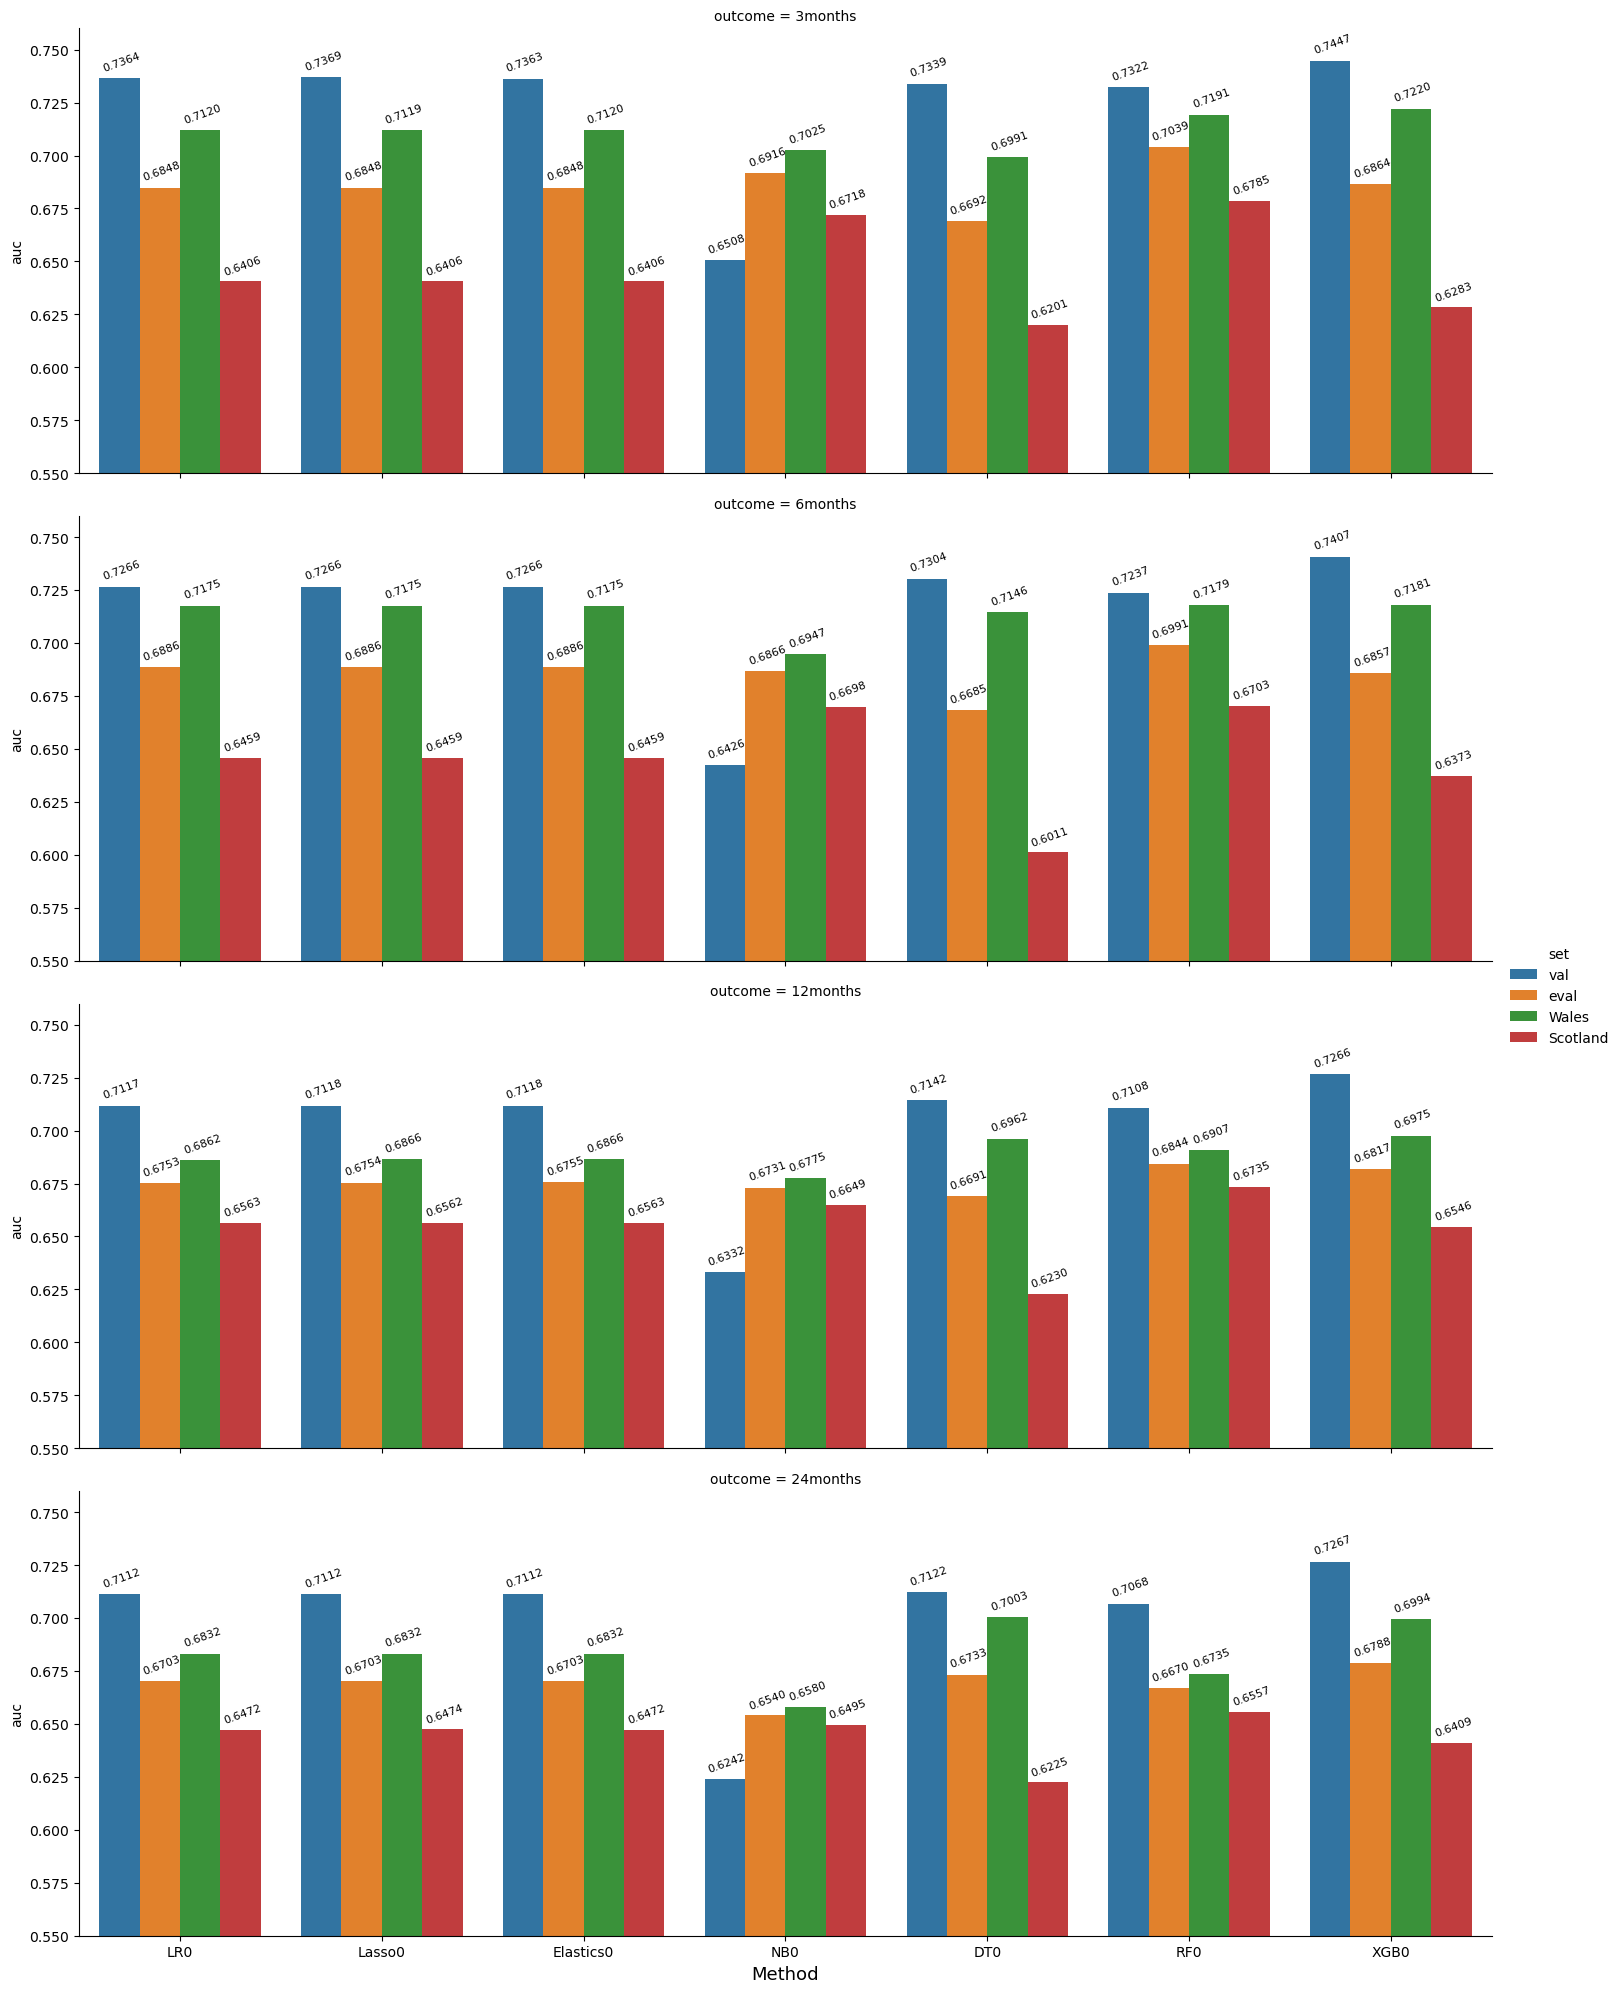

In [88]:
data = combine
# data = combine[combine.set!='Training Set']
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=5,
            row='outcome',
            aspect=3,
            errorbar = None,)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.005, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=8)

ax.set_ylim(0.55, 0.76)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=13)

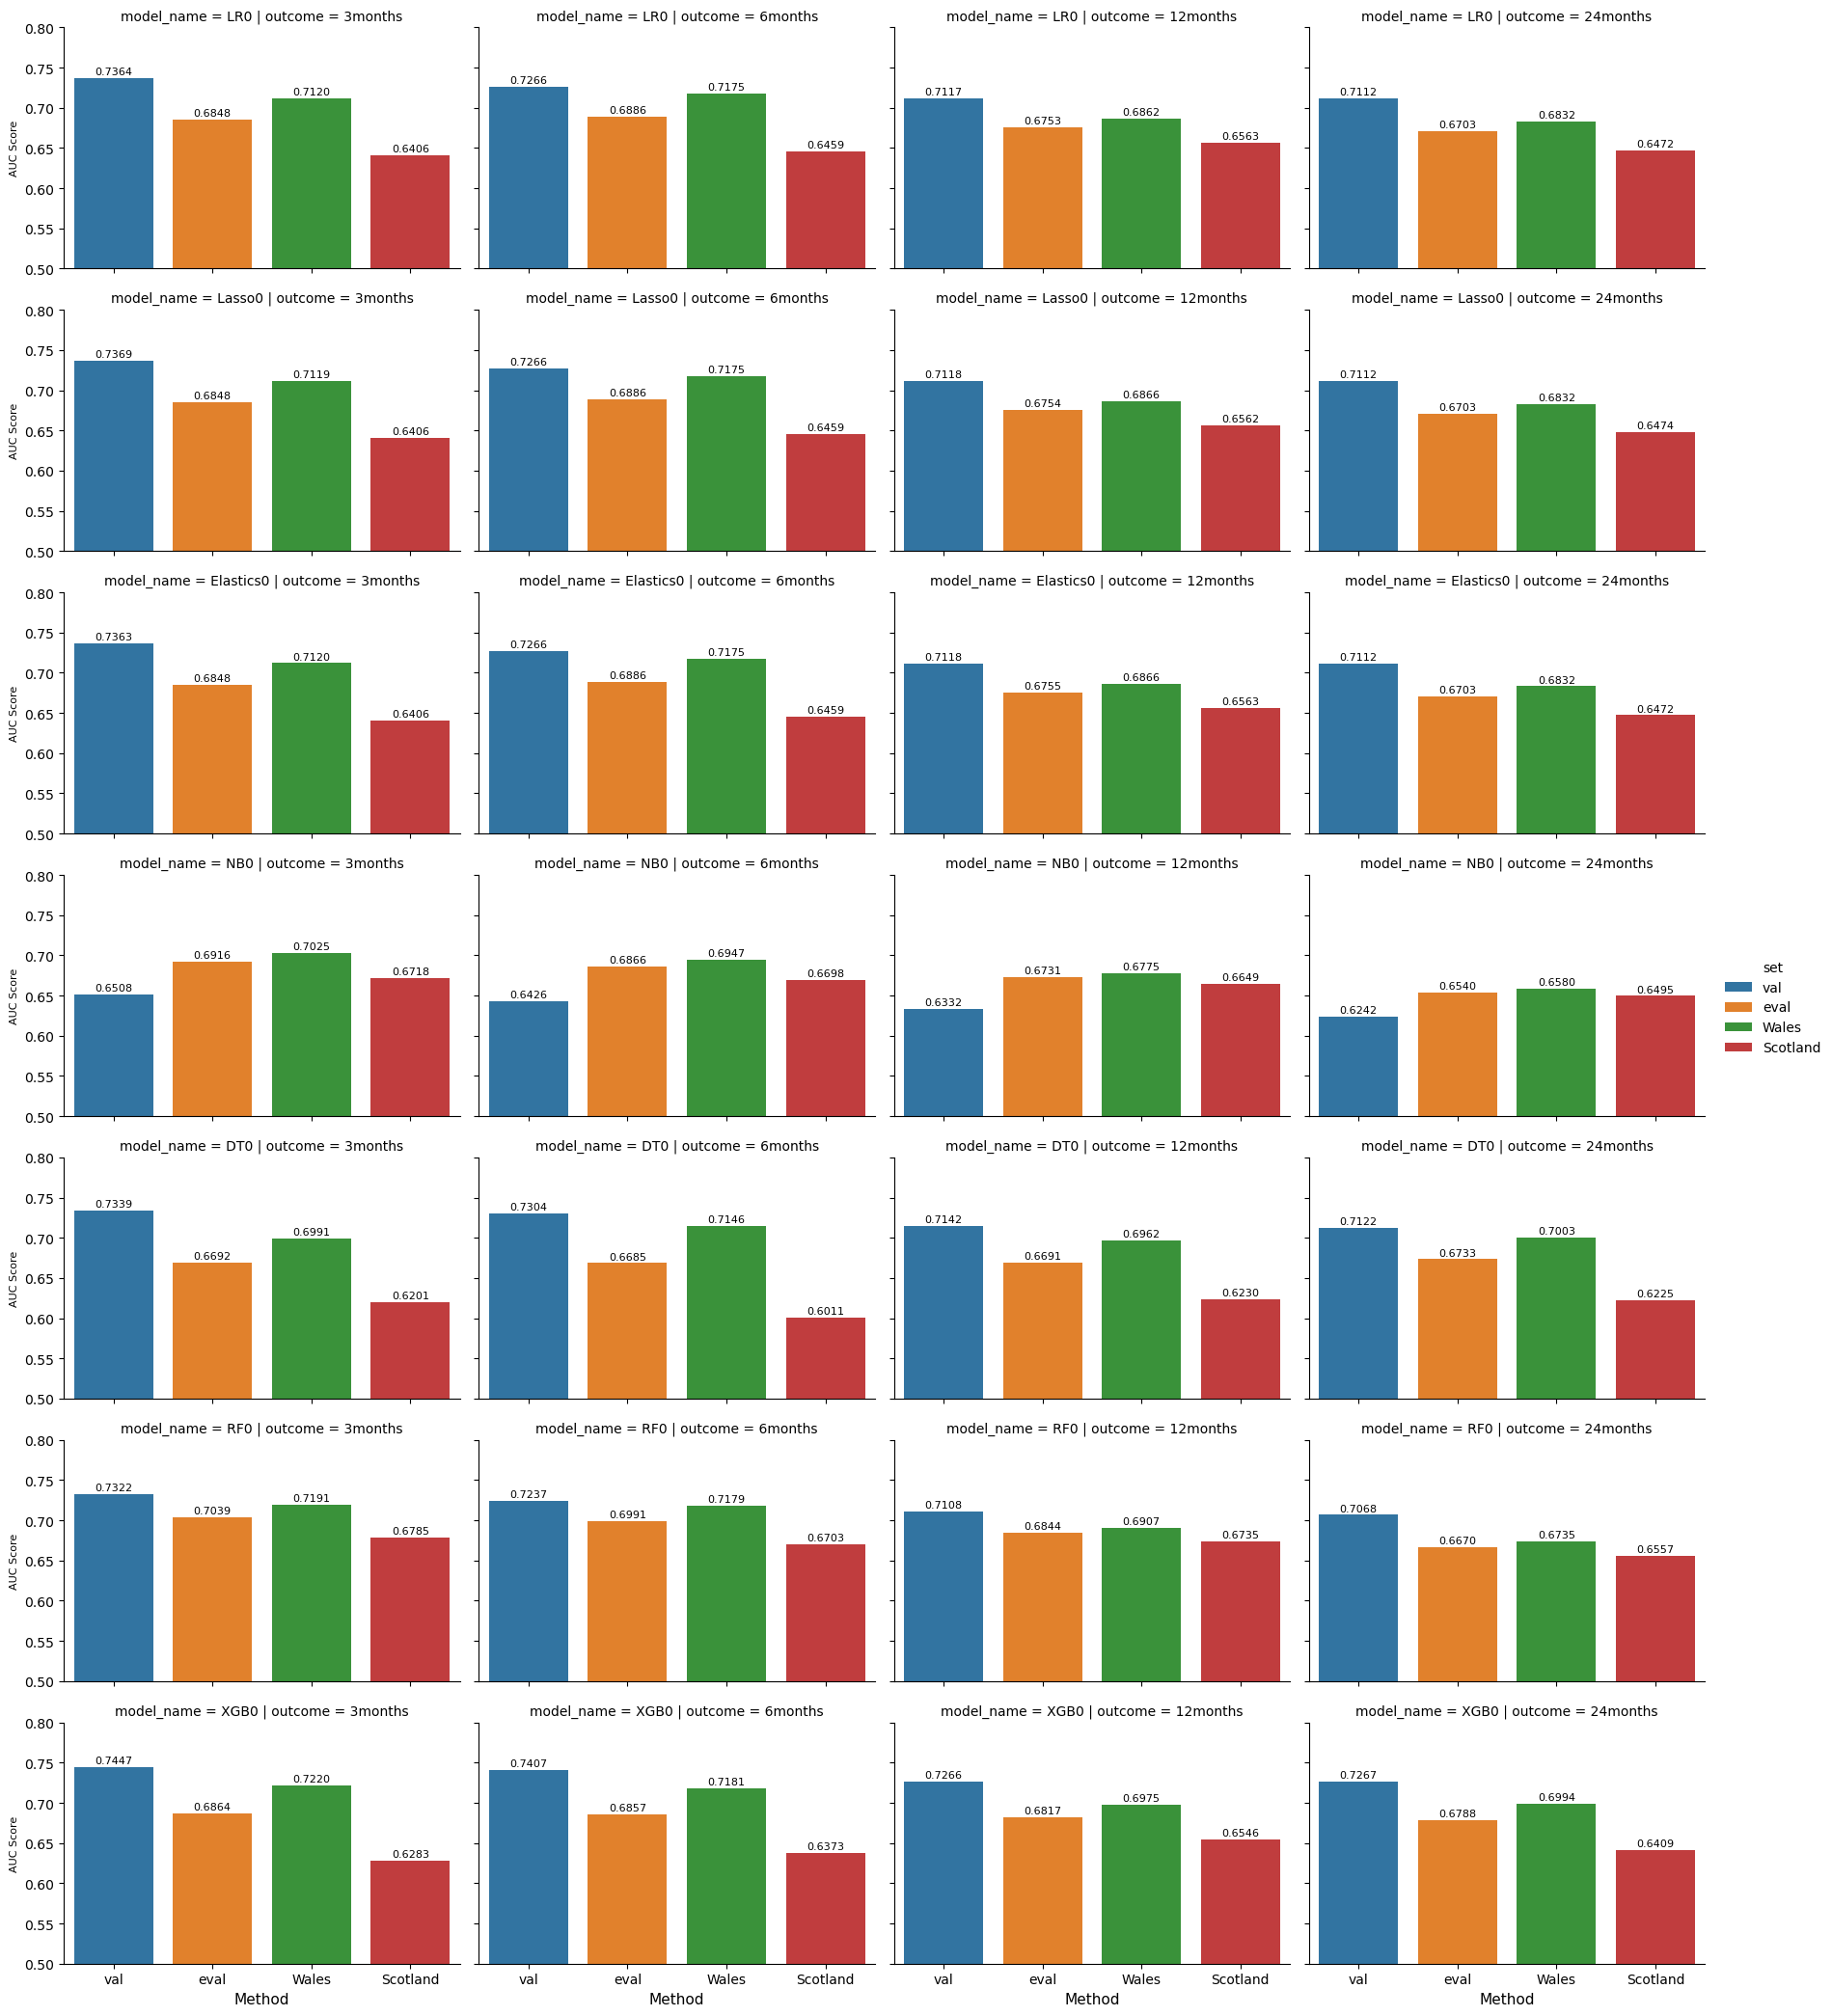

In [89]:
g = sns.FacetGrid(combine, col='outcome', row='model_name', hue = 'set', height=3, aspect=1.5, ylim=(0.5, 0.8))
g.map(sns.barplot, 'set', 'auc', order=combine.set.unique()).add_legend()

for ax in g.axes:
    for item in ax:
        for p in item.patches:
                 item.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                     textcoords='offset points')
        item.set_ylabel('AUC Score', fontsize=8)
        item.set_xlabel('Method', fontsize=11)

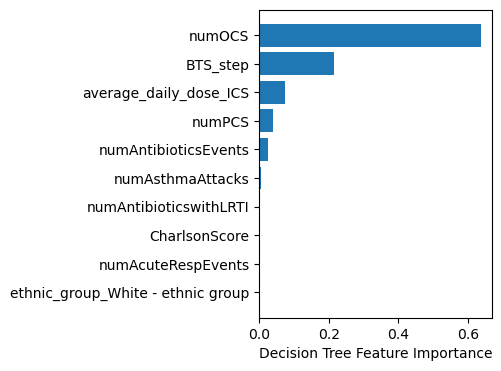

In [90]:
best_model_dt = pickle.load(open('../Models_trainValEval/12months/DT0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

In [91]:
dttop10 = X.columns[sorted_idx][-10:]

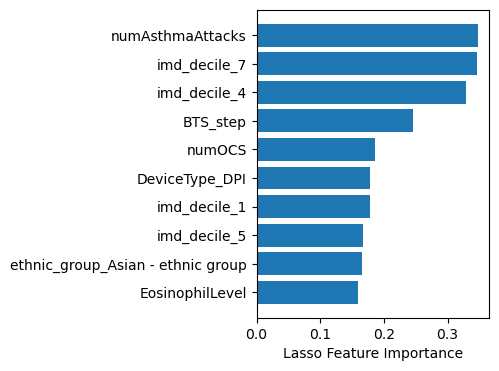

In [92]:
best_model_lasso = pickle.load(open('../Models_trainValEval/12months/Lasso0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lasso.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lasso.coef_[0][sorted_idx][-10:])
plt.xlabel("Lasso Feature Importance")
plt.show()

In [93]:
lassotop10 = X.columns[sorted_idx][-10:]

In [94]:
list(set(dttop10).intersection(set(lassotop10)))

['numAsthmaAttacks', 'numOCS', 'BTS_step']

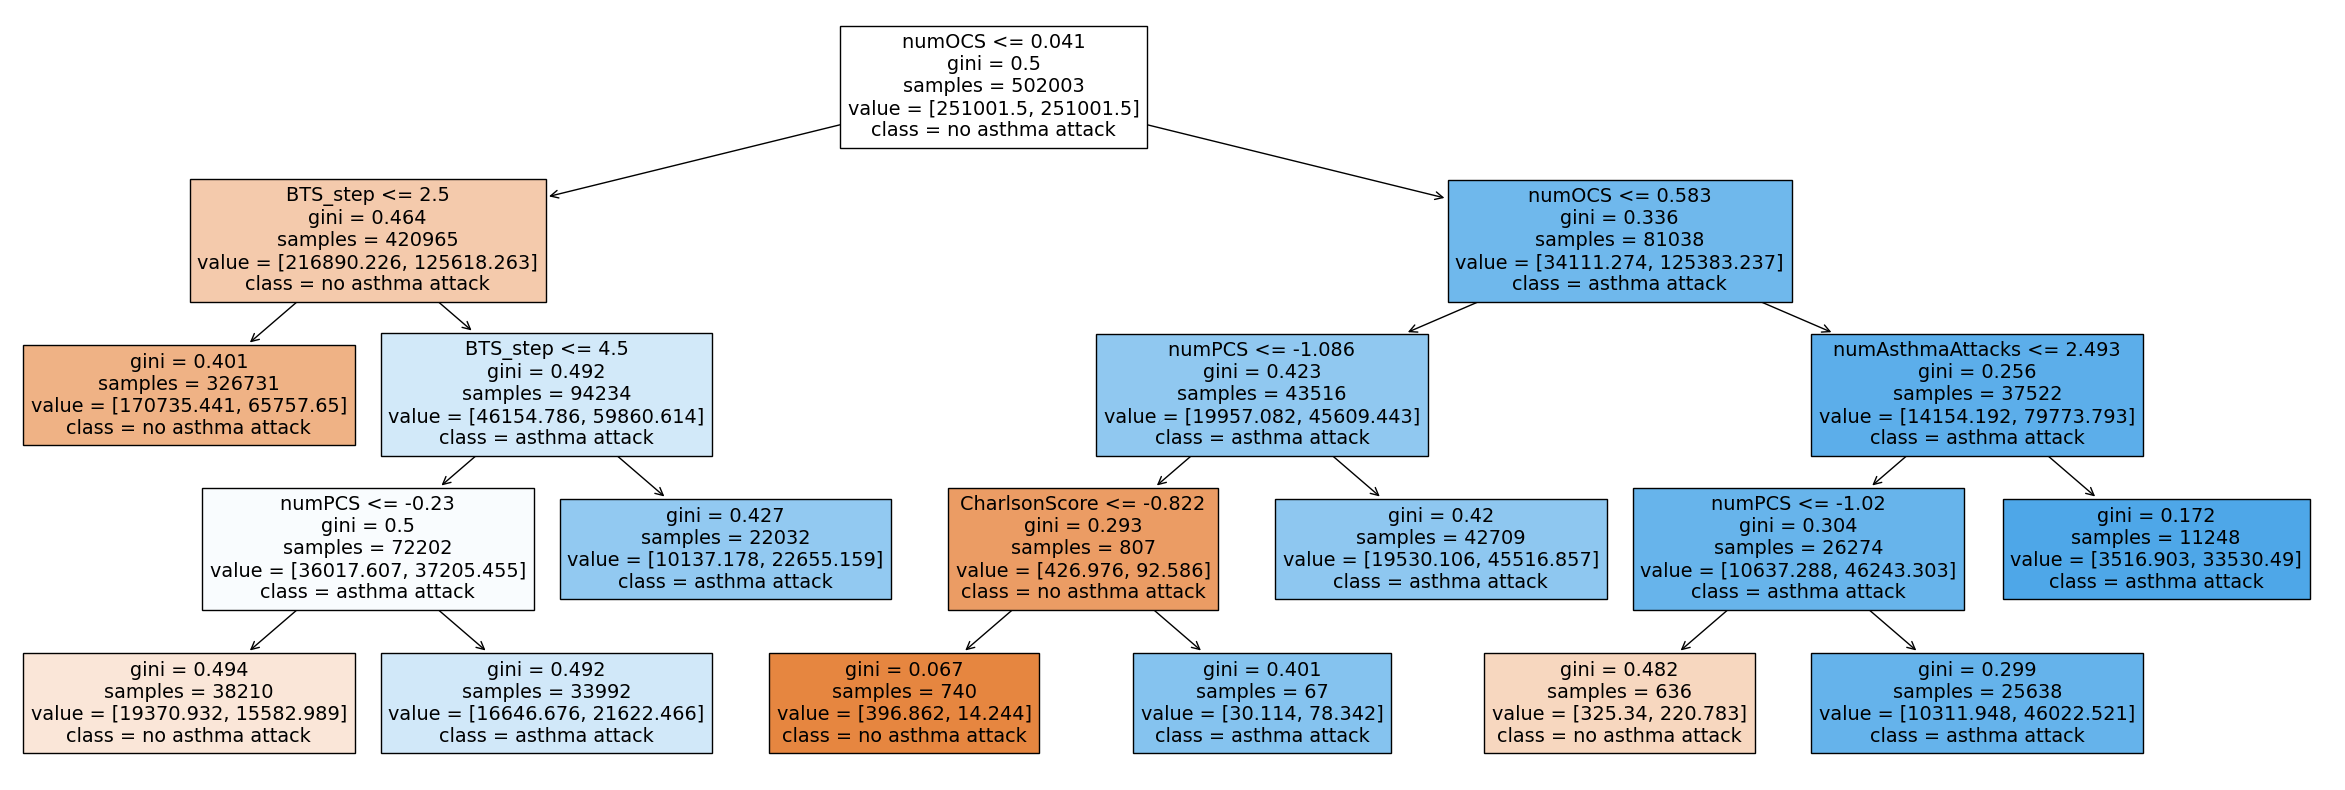

In [95]:
prune_duplicate_leaves(best_model_dt)
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(best_model_dt, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True,)
plt.savefig('../FinalData/dt.png',format='png',bbox_inches = "tight")

## Minimum depth DT

In [147]:
%%time
#DT with minimum max of depth

#EXECUTE model training
# X = trainingData[features_columns]
# X_test = evaluationData[features_columns]
target_outcome = '12months'

print(target_outcome)
y = trainingData[target_outcome]
y_test = evaluationData[target_outcome]
#Build models -> it can be commented if the models have been trained

# if os.path.isfile('../Models_trainValEval/dt_minimum_depth.sav'):
#     dt_model = pickle.load(open('../Models_trainValEval/dt_minimum_depth.sav', 'rb'))
# else:
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=7, splitter='best', random_state=1234)
dt_model.fit(X, y)
pickle.dump(dt_model, open('../Models_trainValEval/dt_minimum_depth.sav', 'wb'))    
    

print(summariseResult (X_val, y_val, dt_model))
print(summariseResult (X_eval, y_eval, dt_model))
print(summariseResult (X_eval_Wales, y_eval_Wales, dt_model))
print("DT done")

12months
(0.756, 0.7655, 0.6734, 0.7195, 0.201, 0.7195, 0.3629, 24.8398, 95.3205)
(0.6814, 0.6813, 0.6818, 0.6816, 0.2102, 0.6816, 0.362, 24.6417, 93.337)
(0.7023, 0.7022, 0.7033, 0.7027, 0.2325, 0.7027, 0.393, 27.271, 93.7113)
DT done
CPU times: user 2.81 s, sys: 101 ms, total: 2.91 s
Wall time: 2.91 s


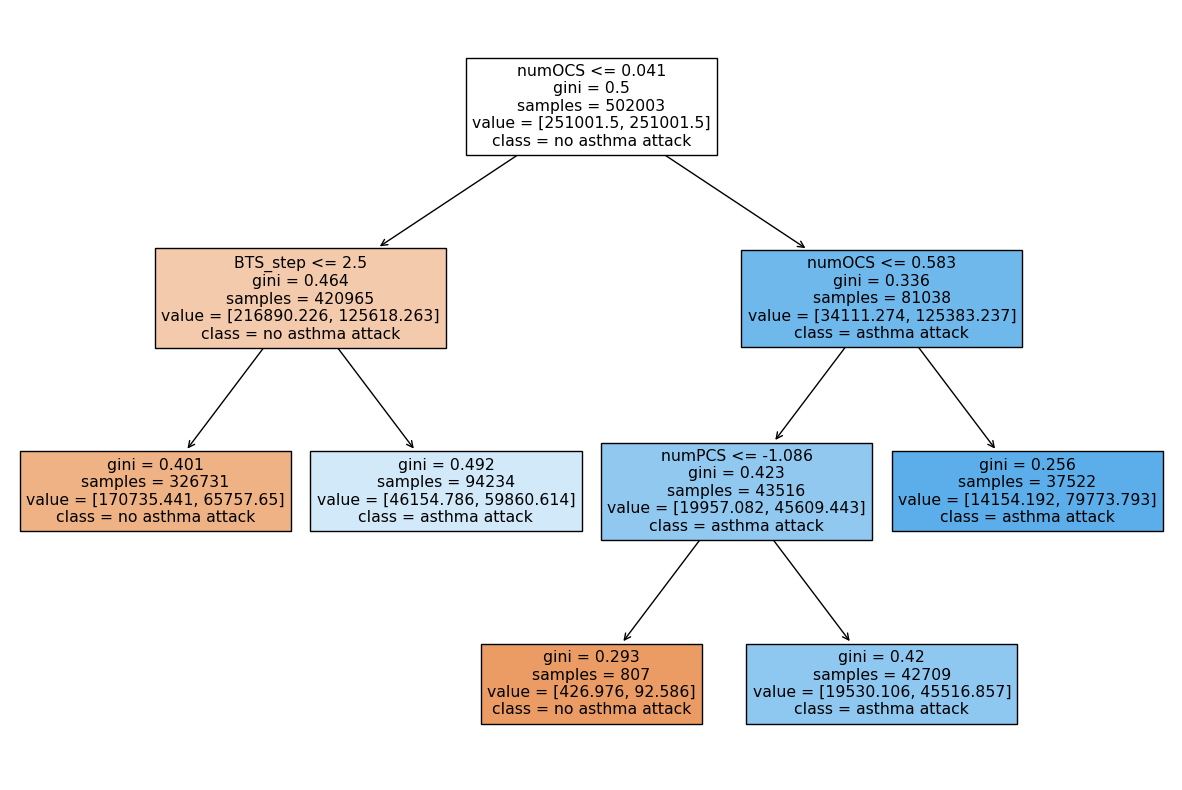

In [117]:
prune_duplicate_leaves(dt_model)
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(dt_model, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True)
plt.savefig('../FinalData/dt_minimumdepth.png',format='png',bbox_inches = "tight")

In [109]:
scaler = pickle.load(open('../Models_trainValEval/cont_scaler.pkl', 'rb'))
continuous_vars = ['age', 'CharlsonScore', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 
                   'numOCS', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 
                   'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents']

In [110]:
DataOfInterest_cont = pd.DataFrame(scaler.inverse_transform(trainingData[continuous_vars]), columns=scaler.get_feature_names_out())

In [112]:
VarOfInterest = ['numOCS', 'numPCS']
additionalVars = ['prescribed_daily_dose_ICS', 'numAntibioticsEvents', 'ICS_medication_possesion_ratio', 'numAsthmaAttacks', 'numAntibioticswithLRTI', 'age']
DataOfInterest = pd.concat((DataOfInterest_cont, trainingData[['BTS_step', 'imd_decile_0']+target_outcomes]), axis=1)
#solve little problem with inverse scaling:
DataOfInterest['numAsthmaAttacks'] = DataOfInterest.numAsthmaAttacks.apply(lambda x: 0 if x<1 else x)
DataOfInterest['numOCSwithLRTI'] = DataOfInterest.numOCSwithLRTI.apply(lambda x: 0 if x<1 else x)
DataOfInterest['numHospEvents'] = DataOfInterest.numHospEvents.apply(lambda x: 0 if x<1 else x)
DataOfInterest.head()

,age,CharlsonScore,average_daily_dose_ICS,prescribed_daily_dose_ICS,ICS_medication_possesion_ratio,numOCS,numPCS,numPCSAsthma,numAntibioticsEvents,numAntibioticswithLRTI,...,numOCSwithLRTI,numAsthmaAttacks,numAcuteRespEvents,numHospEvents,BTS_step,imd_decile_0,3months,6months,12months,24months
0,34.0,1.0,0.0,-2.842171e-14,0.000000,0.0,7.0,0.0,1.110223e-16,0.0,...,0.0,0.0,1.734723e-17,0.0,1.0,0.0,0,0,0,0
1,81.0,1.0,200.0,2.000000e+02,0.136893,0.0,19.0,1.0,1.110223e-16,0.0,...,0.0,0.0,1.734723e-17,0.0,1.0,0.0,0,0,0,0
2,60.0,1.0,400.0,4.000000e+02,0.136893,0.0,7.0,0.0,1.110223e-16,0.0,...,0.0,0.0,1.734723e-17,0.0,1.0,0.0,0,0,0,0
3,33.0,1.0,0.0,-2.842171e-14,0.000000,0.0,39.0,2.0,1.110223e-16,0.0,...,0.0,0.0,1.734723e-17,0.0,3.0,0.0,0,0,0,0
4,65.0,4.0,200.0,2.000000e+02,0.273785,1.0,39.0,1.0,2.000000e+00,0.0,...,1.0,1.0,1.734723e-17,0.0,1.0,0.0,0,0,1,1


In [113]:
scaler.feature_names_in_

array(['age', 'CharlsonScore', 'average_daily_dose_ICS',
       'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio',
       'numOCS', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents',
       'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI',
       'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents'],
      dtype=object)

In [125]:
depth3_1 = [[0, 0, 0,
       0, 0,
       0.041, -1.086, 0, 0,
       0, 0, 0,
       0, 0, 0]]

depth3_2 = [[0, 0, 0,
       0, 0,
       0.583, -1.086, 0, 0,
       0, 0, 0,
       0, 0, 0]]

depth4_1 = [[0, -0.822, 0,
       0, 0,
       0.041, -0.23, 0, 0,
       0, 0, 0,
       2.493, 0, 0]]

depth4_2 = [[0, -0.822, 0,
       0, 0,
       0.583, -1.02, 0, 0,
       0, 0, 0,
       2.493, 0, 0]]

In [126]:
scaler.inverse_transform(depth3_1)

array([[4.91399195e+01, 1.30145836e+00, 2.46999759e+02, 2.45858423e+02,
        6.43838392e-02, 5.00047423e-01, 4.93457217e-01, 8.02043016e-01,
        7.00089442e-01, 2.93896650e-01, 4.24389894e-01, 2.11598337e-01,
        2.48313257e-01, 2.44938775e-02, 5.99996414e-03]])

In [127]:
scaler.inverse_transform(depth3_2)

array([[4.91399195e+01, 1.30145836e+00, 2.46999759e+02, 2.45858423e+02,
        6.43838392e-02, 1.50020304e+00, 4.93457217e-01, 8.02043016e-01,
        7.00089442e-01, 2.93896650e-01, 4.24389894e-01, 2.11598337e-01,
        2.48313257e-01, 2.44938775e-02, 5.99996414e-03]])

In [133]:
scaler.inverse_transform(depth4_1)

array([[4.91399195e+01, 4.99833884e-01, 2.46999759e+02, 2.45858423e+02,
        6.43838392e-02, 5.00047423e-01, 1.35036258e+01, 8.02043016e-01,
        7.00089442e-01, 2.93896650e-01, 4.24389894e-01, 2.11598337e-01,
        2.49964898e+00, 2.44938775e-02, 5.99996414e-03]])

In [135]:
scaler.inverse_transform(depth4_2)

array([[4.91399195e+01, 4.99833884e-01, 2.46999759e+02, 2.45858423e+02,
        6.43838392e-02, 1.50020304e+00, 1.49657769e+00, 8.02043016e-01,
        7.00089442e-01, 2.93896650e-01, 4.24389894e-01, 2.11598337e-01,
        2.49964898e+00, 2.44938775e-02, 5.99996414e-03]])

<Axes: >

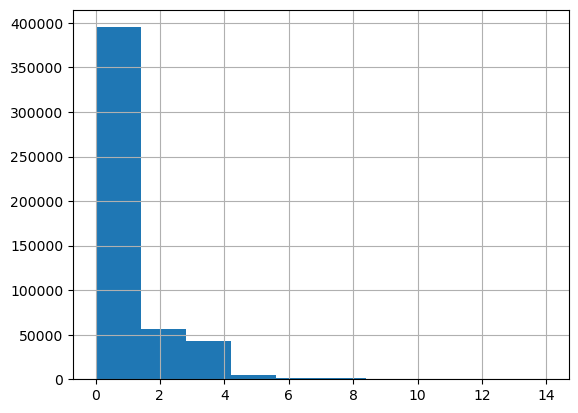

In [138]:
DataOfInterest.CharlsonScore.hist()

In [149]:
preds_dt = best_model_dt.predict(trainingData[features_columns])
preds_lasso = best_model_lasso.predict(trainingData[features_columns])
prediction_table = pd.DataFrame([trainingData['12months'], preds_dt, preds_lasso]).T
prediction_table.columns = ['y_true', 'y_pred_dt', 'y_pred_lasso']

In [150]:
false_positive = prediction_table[(prediction_table.y_pred_dt==1) & (prediction_table.y_true!=prediction_table.y_pred_dt)]
false_negative = prediction_table[(prediction_table.y_pred_dt==0) & (prediction_table.y_true!=prediction_table.y_pred_dt)]
true_positive = prediction_table[(prediction_table.y_pred_dt==1) & (prediction_table.y_true==prediction_table.y_pred_dt)]
true_negative = prediction_table[(prediction_table.y_pred_dt==0) & (prediction_table.y_true==prediction_table.y_pred_dt)]

In [154]:
print('True Pos')
print(DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].describe())
print('-----------------------------------------------------------------------------------')
print('False Neg')
print(DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].describe())
print('-----------------------------------------------------------------------------------')
# print('False Pos')
# print(DataOfInterest.iloc[false_positive.index][VarOfInterest+['BTS_step']].describe())
# print('-----------------------------------------------------------------------------------')
# print('True Neg')
# print(DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']].describe())

True Pos
             numOCS        numPCS      BTS_step
count  23789.000000  23789.000000  23789.000000
mean       2.871916     27.117071      3.064021
std        5.184744     18.813340      1.933999
min        0.000000      0.000000      0.000000
25%        0.000000     14.000000      1.000000
50%        1.000000     23.000000      3.000000
75%        3.000000     35.000000      5.000000
max       96.000000    301.000000      5.000000
-----------------------------------------------------------------------------------
False Neg
             numOCS        numPCS      BTS_step
count  11454.000000  11454.000000  11454.000000
mean       0.018072     16.870787      0.943077
std        0.584086     14.815913      1.235017
min        0.000000      0.000000      0.000000
25%        0.000000      7.000000      0.000000
50%        0.000000     12.000000      0.000000
75%        0.000000     22.000000      1.000000
max       51.000000    178.000000      5.000000
---------------------------------

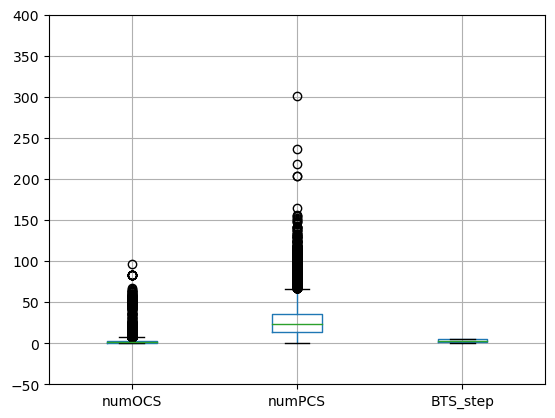

-----------------------------------------------------------------------------------


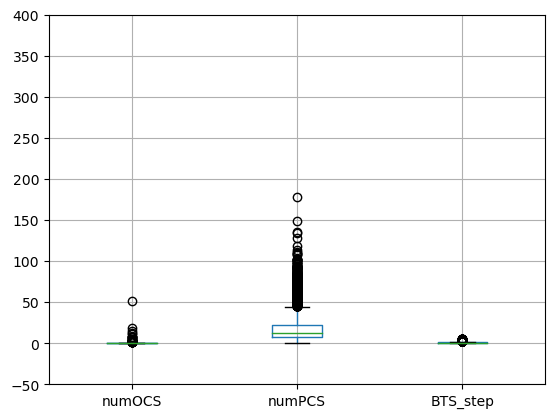

-----------------------------------------------------------------------------------


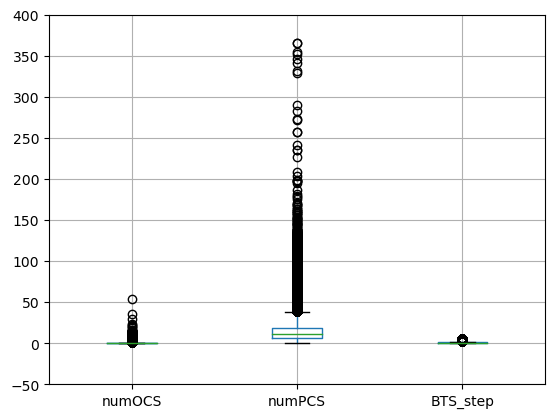

In [156]:
fig, ax = plt.subplots()
DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].boxplot(ax=ax)
ax.set_ylim(-50,400)
plt.show()
print('-----------------------------------------------------------------------------------')
fig, ax = plt.subplots()
DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].boxplot()
ax.set_ylim(-50,400)
plt.show()
print('-----------------------------------------------------------------------------------')
fig, ax = plt.subplots()
DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']].boxplot()
ax.set_ylim(-50,400)
plt.show()

In [157]:
print(DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())
print('-----------------------------------------------------------------------------------')
print(DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())
print('-----------------------------------------------------------------------------------')
print(DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())

             numOCS        numPCS      BTS_step  prescribed_daily_dose_ICS  \
count  23789.000000  23789.000000  23789.000000               2.378900e+04   
mean       2.871916     27.117071      3.064021               5.077160e+02   
std        5.184744     18.813340      1.933999               4.309040e+02   
min        0.000000      0.000000      0.000000              -2.842171e-14   
25%        0.000000     14.000000      1.000000               2.000000e+02   
50%        1.000000     23.000000      3.000000               4.000000e+02   
75%        3.000000     35.000000      5.000000               8.000000e+02   
max       96.000000    301.000000      5.000000               7.500000e+03   

       numAntibioticsEvents  ICS_medication_possesion_ratio  numAsthmaAttacks  \
count          2.378900e+04                    23789.000000      23789.000000   
mean           2.660557e+00                        0.088227          1.586069   
std            3.693452e+00                        0.0

In [162]:
DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].sample(n=20, random_state=1234)

,numOCS,numPCS,BTS_step
90970,5.0,48.0,3.0
9590,0.0,24.0,3.0
362050,48.0,58.0,5.0
16877,0.0,34.0,5.0
234095,0.0,8.0,5.0
74230,0.0,39.0,3.0
324524,4.0,17.0,4.0
387723,1.0,12.0,3.0
180049,5.0,49.0,5.0
285742,3.0,55.0,5.0


In [163]:
DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].sample(n=20, random_state=1234)

,numOCS,numPCS,BTS_step
378434,0.0,8.0,3.0
265746,0.0,17.0,0.0
492770,0.0,38.0,0.0
126924,0.0,14.0,0.0
15260,0.0,15.0,0.0
307125,0.0,8.0,3.0
187997,0.0,9.0,3.0
210914,0.0,35.0,0.0
277762,0.0,13.0,4.0
464696,0.0,3.0,0.0


## Run models only on the subset of BTS == 1

In [69]:
trainingDataSubset = trainingData[(trainingData.BTS_step < 7)]
validationDataSubset = validationData[(validationData.BTS_step < 7) ]
evaluationDataSubset = evaluationData[(evaluationData.BTS_step < 7)]
evaluationDataWalesSubset = evaluationDataWales[(evaluationDataWales.BTS_step < 7) ]
evaluationDataScotlandSubset = evaluationDataScotland[(evaluationDataScotland.BTS_step < 7)]

In [70]:
#encode categorical data

# cat_vars = ['PEFStatus','EosinophilLevel']
onehot_vars = ['BTS_step']
# data_categorical = trainingData[cat_vars]
data_onehot = trainingDataSubset[onehot_vars]

# #ordinal encoder
# encoder = OrdinalEncoder(categories=[['not_recorded','less than 60', '60-80', 'more than 80'], ['unknown', 'normal', 'high']]).set_output(transform="pandas")
# data_encoded = encoder.fit_transform(data_categorical)
# pickle.dump(encoder, open('../Models/cat_encoder.pkl', 'wb'))
    
#one hot encoder
onehot_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
onehot_encoded = onehot_encoder.fit_transform(data_onehot)
# pickle.dump(onehot_encoder, open('../Models/onehot_encoder.pkl', 'wb'))

# trainingDataSubset = pd.concat([trainingDataSubset.drop(cat_vars, axis=1), data_encoded], axis=1)
trainingDataSubset = pd.concat([trainingDataSubset.drop(onehot_vars, axis=1), onehot_encoded], axis=1)

print('Data shape after encoding: ', trainingDataSubset.shape)

Data shape after encoding:  (502003, 130)


In [71]:
#encode cat vars for validation and evaluation set
# data_val_categorical = validationData[cat_vars]
data_val_onehot = validationDataSubset[onehot_vars]
# data_eval_categorical = evaluationData[cat_vars]
data_eval_onehot = evaluationDataSubset[onehot_vars]
# data_eval_Wales_categorical = evaluationDataWales[cat_vars]
data_eval_Wales_onehot = evaluationDataWalesSubset[onehot_vars]
# data_eval_Scotland_categorical = evaluationDataScotland[cat_vars]
data_eval_Scotland_onehot = evaluationDataScotlandSubset[onehot_vars]

# encoder = pickle.load(open('../Models/cat_encoder.pkl', 'rb'))
# data_val_encoded = encoder.transform(data_val_categorical)
# data_eval_encoded = encoder.transform(data_eval_categorical)
# data_eval_Wales_encoded = encoder.transform(data_eval_Wales_categorical)
# data_eval_Scotland_encoded = encoder.transform(data_eval_Scotland_categorical)

# onehot_encoder = pickle.load(open('../Models/onehot_encoder.pkl', 'rb'))
onehot_val_encoded = onehot_encoder.transform(data_val_onehot)
onehot_eval_encoded = onehot_encoder.transform(data_eval_onehot)
onehot_eval_Wales_encoded = onehot_encoder.transform(data_eval_Wales_onehot)
onehot_eval_Scotland_encoded = onehot_encoder.transform(data_eval_Scotland_onehot)

# validationDataSubset = pd.concat([validationDataSubset.drop(cat_vars, axis=1), data_val_encoded], axis=1)
validationDataSubset = pd.concat([validationDataSubset.drop(onehot_vars, axis=1), onehot_val_encoded], axis=1)

# evaluationDataSubset = pd.concat([evaluationDataSubset.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
evaluationDataSubset = pd.concat([evaluationDataSubset.drop(onehot_vars, axis=1), onehot_eval_encoded], axis=1)

# evaluationDataWalesSubset = pd.concat([evaluationDataWalesSubset.drop(cat_vars, axis=1), data_eval_Wales_encoded], axis=1)
evaluationDataWalesSubset = pd.concat([evaluationDataWalesSubset.drop(onehot_vars, axis=1), onehot_eval_Wales_encoded], axis=1)

# evaluationDataScotlandSubset = pd.concat([evaluationDataScotlandSubset.drop(cat_vars, axis=1), data_eval_Scotland_encoded], axis=1)
evaluationDataScotlandSubset = pd.concat([evaluationDataScotlandSubset.drop(onehot_vars, axis=1), onehot_eval_Scotland_encoded], axis=1)

print('Val data shape after encoding: ', validationDataSubset.shape)
print('Eval data shape after encoding: ', evaluationDataSubset.shape)
print('Evaluation data Wales shape: ', evaluationDataWalesSubset.shape)
print('Evaluation data Scotland shape: ', evaluationDataScotlandSubset.shape)

Val data shape after encoding:  (55779, 130)
Eval data shape after encoding:  (22825, 130)
Evaluation data Wales shape:  (14485, 130)
Evaluation data Scotland shape:  (8340, 130)


In [72]:
trainingDataSubset.shape

(502003, 130)

In [77]:
trainingDataSubset.columns

Index(['patid', 'practice_id', 'sex', 'BMI', 'ethnicity', 'count_rhinitis',
       'count_cardiovascular', 'count_heartfailure', 'count_psoriasis',
       'count_anaphylaxis',
       ...
       'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents',
       'numHospEvents', 'BTS_step_0.0', 'BTS_step_1.0', 'BTS_step_2.0',
       'BTS_step_3.0', 'BTS_step_4.0', 'BTS_step_5.0'],
      dtype='object', length=130)

In [78]:
features_columns.remove('BTS_step')
features_columns = features_columns + ['BTS_step_0.0', 'BTS_step_1.0', 'BTS_step_2.0',
                                       'BTS_step_3.0', 'BTS_step_4.0', 'BTS_step_5.0']
features_columns

['sex',
 'PriorEducation',
 'rhinitis',
 'cardiovascular',
 'heartfailure',
 'psoriasis',
 'anaphylaxis',
 'diabetes',
 'ihd',
 'anxiety',
 'eczema',
 'nasalpolyps',
 'PEFStatus',
 'EosinophilLevel',
 'ethnic_group_Asian - ethnic group',
 'ethnic_group_Black - ethnic group',
 'ethnic_group_Mixed ethnic census group',
 'ethnic_group_Other ethnic group',
 'ethnic_group_White - ethnic group',
 'ethnic_group_not_recorded',
 'smokingStatus_Active Smoker',
 'smokingStatus_Former Smoker',
 'smokingStatus_Non Smoker',
 'DeviceType_BAI',
 'DeviceType_DPI',
 'DeviceType_NEB',
 'DeviceType_pMDI',
 'DeviceType_unknown',
 'cat_BMI_normal',
 'cat_BMI_not recorded',
 'cat_BMI_obese',
 'cat_BMI_overweight',
 'cat_BMI_underweight',
 'imd_decile_0',
 'imd_decile_1',
 'imd_decile_2',
 'imd_decile_3',
 'imd_decile_4',
 'imd_decile_5',
 'imd_decile_6',
 'imd_decile_7',
 'imd_decile_8',
 'imd_decile_9',
 'imd_decile_10',
 'age',
 'CharlsonScore',
 'average_daily_dose_ICS',
 'prescribed_daily_dose_ICS',
 'IC

In [79]:
X_subset = trainingDataSubset[features_columns]
X_val_subset = validationDataSubset[features_columns]
X_eval_subset = evaluationDataSubset[features_columns]
X_eval_Wales_subset = evaluationDataWalesSubset[features_columns]
X_eval_Scotland_subset = evaluationDataScotlandSubset[features_columns]
target_outcomes = ['3months', '6months', '12months', '24months'] 

In [80]:
X_subset.shape

(502003, 64)

In [81]:
X_subset.shape[0]/trainingData.shape[0]

1.0

In [82]:
%%time


#EXECUTE model training
summary_result_val_subset = []
summary_result_eval_subset = []
summary_result_Wales_subset = []
summary_result_Scotland_subset = []
cols = ['model_name', 'outcome', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
model_folder = '../Models_subsetBTS/'
fold = 0

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y_subset = trainingDataSubset[target_outcome]
    y_val_subset = validationDataSubset[target_outcome]
    y_eval_subset = evaluationDataSubset[target_outcome]
    y_eval_Wales_subset = evaluationDataWalesSubset[target_outcome]
    y_eval_Scotland_subset = evaluationDataScotlandSubset[target_outcome]
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_subset, y_subset, target_outcome, params_dict, model_folder, fold), columns=['modelname', 'target_outcome', 'class_ratio'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)

    #evaluate model
    for modelname, target_outcome, classratio in models.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open(model_folder+ target_outcome + '/'+ modelname + '.sav', 'rb'))
        summary_result_eval_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_subset, y_eval_subset, model) )
        summary_result_Wales_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Wales_subset, y_eval_Wales_subset, model) )       
        summary_result_Scotland_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Scotland_subset, y_eval_Scotland_subset, model) )       
        summary_result_val_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_val_subset, y_val_subset, model) )       


summary_result_eval_subset = pd.DataFrame(summary_result_eval_subset, columns=cols)
summary_result_eval_subset['model_num'] = summary_result_eval_subset.index

summary_result_Wales_subset = pd.DataFrame(summary_result_Wales_subset, columns=cols)
summary_result_Wales_subset['model_num'] = summary_result_Wales_subset.index

summary_result_Scotland_subset = pd.DataFrame(summary_result_Scotland_subset, columns=cols)
summary_result_Scotland_subset['model_num'] = summary_result_Scotland_subset.index

summary_result_val_subset = pd.DataFrame(summary_result_val_subset, columns=cols)
summary_result_val_subset['model_num'] = summary_result_val_subset.index


3months
Building models . . . .
{'solver': 'liblinear', 'C': 0.3110204078235362, 'max_iter': 161}
LR done
{'solver': 'saga', 'C': 5.264286812182277, 'max_iter': 73}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.12538683368444242, 'max_iter': 328}
Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7}
DT done
{'criterion': 'gini', 'n_estimators': 281, 'max_depth': 7}
RF done
{'n_estimators': 251, 'max_depth': 7, 'learning_rate': 0.017952118813409648, 'reg_alpha': 0.0038566417152755203, 'reg_lambda': 1.547768166339415e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
6months
Building models . . . .
{'solver': 'liblinear', 'C': 4.029759596937809, 'max_iter': 65}
LR done
{'solver': 'saga', 'C': 5.264286812182277, 'max_iter': 73}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.12538683368444242, 'max_iter': 328}
Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 7}
DT done
{'criterion': 'gini', 'n_estimators': 199, 'max_depth': 7}
RF done
{'n_estimators': 281, 'max_depth': 7, 'learning_rate': 0.014537455903050606, 'reg_alpha': 0.0007300378404486753, 'reg_lambda': 0.0005512251323396136}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
12months
Building models . . . .
{'solver': 'liblinear', 'C': 4.321921577616365, 'max_iter': 142}
LR done
{'solver': 'saga', 'C': 9.424940225483164, 'max_iter': 68}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.14415023448679715, 'max_iter': 358}
Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 7}
DT done
{'criterion': 'gini', 'n_estimators': 199, 'max_depth': 7}
RF done
{'n_estimators': 251, 'max_depth': 7, 'learning_rate': 0.017952118813409648, 'reg_alpha': 0.0038566417152755203, 'reg_lambda': 1.547768166339415e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
24months
Building models . . . .
{'solver': 'liblinear', 'C': 0.8043769526753184, 'max_iter': 131}
LR done
{'solver': 'saga', 'C': 5.264286812182277, 'max_iter': 73}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'l1_ratio': 0.15794968314524718, 'max_iter': 708}
Elastics done
{'var_smoothing': 2.771271564091625e-06}
GNB done
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 7}
DT done
{'criterion': 'gini', 'n_estimators': 199, 'max_depth': 7}
RF done
{'n_estimators': 281, 'max_depth': 7, 'learning_rate': 0.014537455903050606, 'reg_alpha': 0.0007300378404486753, 'reg_lambda': 0.0005512251323396136}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
NB0
DT0
RF0
XGB0
CPU times: user 16min 45s, sys: 30.9 s, total: 17min 16s
Wall time: 16min 12s


In [83]:
summary_result_val_subset['set'] = 'val'
summary_result_eval_subset['set'] = 'eval'
summary_result_Wales_subset['set'] = 'Wales'
summary_result_Scotland_subset['set'] = 'Scotland'

combine_subset = pd.concat([summary_result_val_subset, summary_result_eval_subset, 
                     summary_result_Wales_subset, summary_result_Scotland_subset,
                    ])

Text(0.5, 29.1406250000001, 'Method')

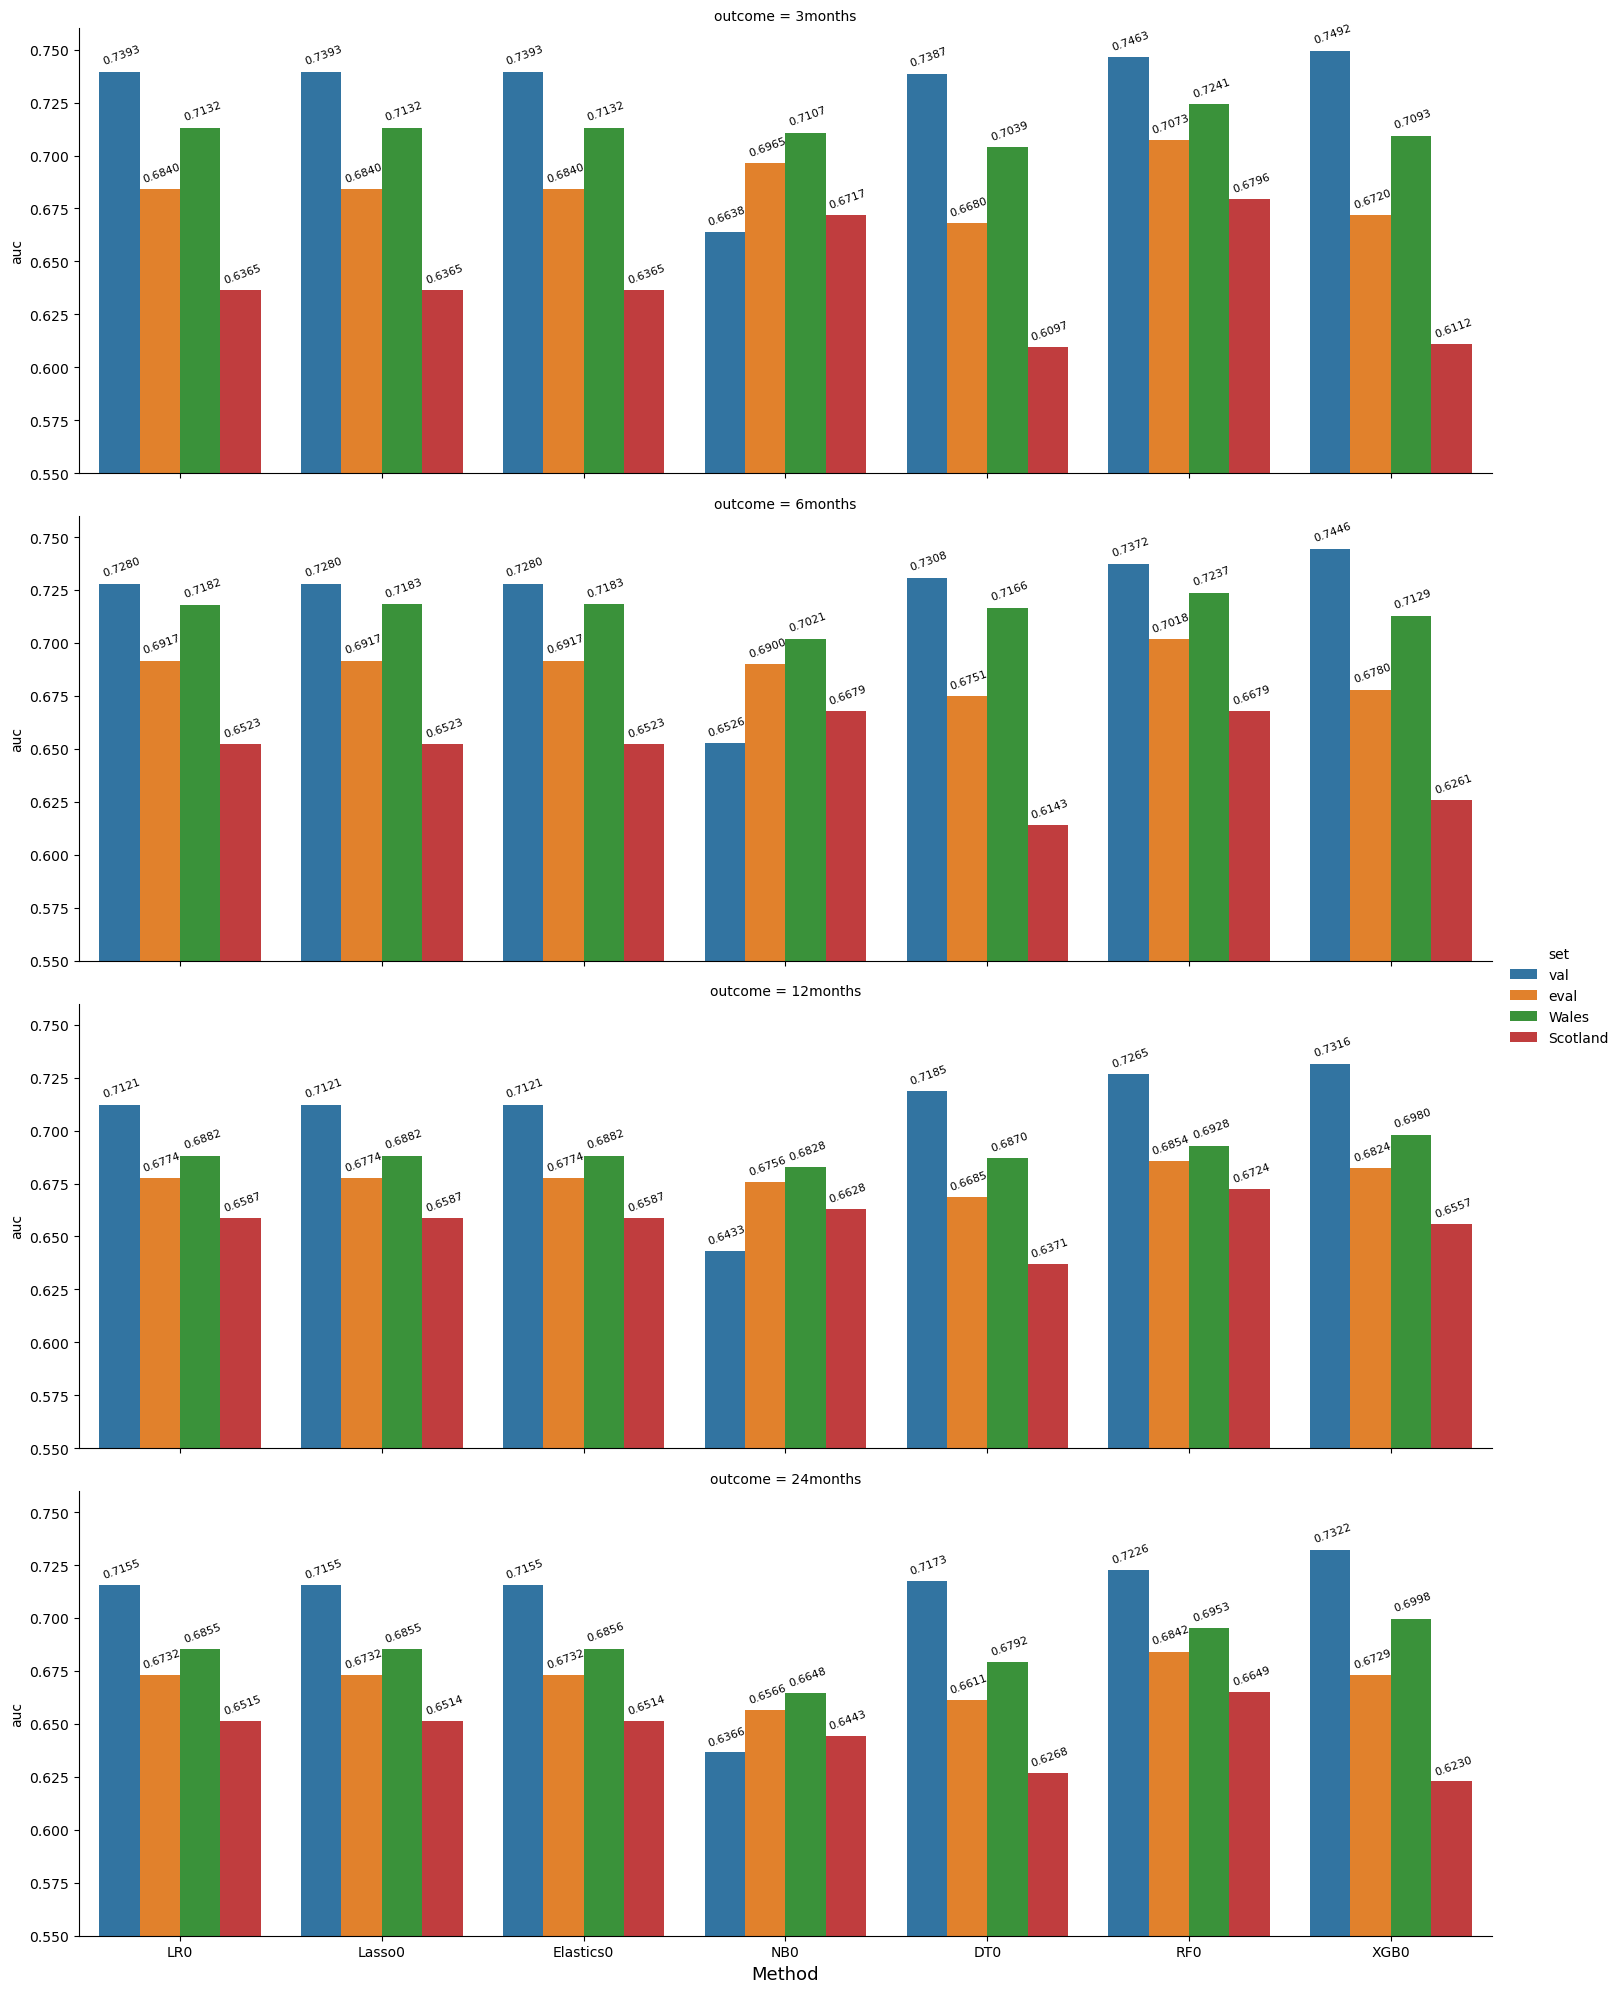

In [84]:
data = combine_subset
# data = combine[combine.set!='Training Set']
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=5,
            row='outcome',
            aspect=3,
            errorbar = None,)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.005, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=8)

ax.set_ylim(0.55, 0.76)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=13)

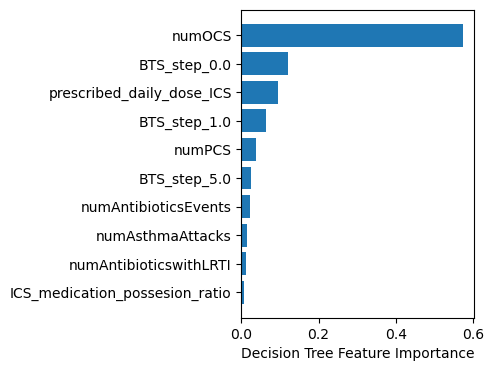

In [86]:
best_model_dt = pickle.load(open('../Models_subsetBTS/12months/DT0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X_subset.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()